# Incorporating fine grained/additional labels with custom loss function in Google Contrail competition

## The competition

[Google Research - Identify Contrails to Reduce Global Warming](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/overview) was hosted on Kaggle and tasked competitors to create a segmentation model which creates a pixel mask marking contrails on sattelite data.
The quotes and images linked here are taken from googles accompanying material.[[1]](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming)[[2]](https://www.kaggle.com/code/inversion/visualizing-contrails)

![contrails](https://storage.googleapis.com/kaggle-media/competitions/Google-Contrails/waterdroplets.png)

![masks](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F59561%2F590a0bc76044a4ceb71368cf3b62412e%2Fcontrails_600.png?generation=1683669162469942&alt=media)

### Labels

My experiment centers around one interesting feature of the competition: The extra label information provided.
For each data point, besides the ground truth pixel mask, the individual human annotator masks -of which the ground truth mask is computed- are also available for training.

> Ground truth was determined by (generally) 4+ different labelers annotating each image. Pixels were considered a contrail when >50% of the labelers annotated it as such. Individual annotations (human_individual_masks.npy) as well as the aggregated ground truth annotations (human_pixel_masks.npy) are included in the training data. The validation data only includes the aggregated ground truth annotations.

The stark differences between {each individual mask as well as between the individual masks and the ground truth computed from the masks}{the different individual and composite masks can} can easily be seen in an example. 

Ground truth
![ground truth](https://github.com/AlsanArcade/Contrails/blob/main/pictures/ground_truth.png?raw_true)
Individual masks
![Individual masks](https://github.com/AlsanArcade/Contrails/blob/main/pictures/different_masks.png?raw_true)




### Data
{The given training and validation data is massive at 450GB.}
Per data-point in the training data set, there are: 
- Satellite images of eight time steps. Four before timesteps, t0 -the timestep which is annotated- and three after timesteps.
- Nine infrared channels per timestep. 
- Four or more individual pixel masks as well as a ground truth mask
Validation data lacks the individual pixel masks, otherwise it's the same.   
Additionally, metadata information for each record is given, for validation as well as training.  
The data can be found [here](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data)

The annotators are provided with one image per timestep. These ash colour scheme images are false color rgb images computed from the infrared bands 11,13,15. The ash colour scheme is also used in the images displayed here.


And instead of trying to use all time steps I only use timestep t0.
### Evaluation metric

> This competition is evaluated on the global Dice coefficient.

# My experiment
## Intuition
Seeing the stark contrast between each individual annotators masks and also between those and the thereof computed ground truth, I felt that including the individual annotators masks should be a big information gain for the model and lead to a better performing model.((((also contrails in ground truth often not semantically useful?BSC-5))))

## Implementation
A simple way to include this information without much work, but still gain knowledge, seemed to me to punish false positives less if they are present in at least one individual mask. Potentially, this could be combined with punishing false negatives of the ground truth harder as well.  

### Custom loss
To achive this, I replace the F-1/Dice loss on the ground truth mask used currently as loss function in training. For validation, I will continue to use The Dice loss.
For training, I construct a custom loss function, which weigths two F-beta loss functions, one on the ground truth mask and the other one on the union of all individual masks.
For that, I utilize the [Tversky loss](https://smp.readthedocs.io/en/latest/losses.html#tverskyloss) function implemented in the SMP package. For alpha + beta = 1, the tversky loss becomes the F beta loss.   

The loss will be computed like this:   
weight_ground_truth * F-beta_ground_truth(predicted mask, ground truth mask) + (1-weight_ground_truth) * F-beta_union(predicted mask, union of individual masks)   

```
loss_ground_truth = smp.losses.TverskyLoss("binary", alpha=self.alpha, beta=self.beta)(preds, label_gt)
loss_union = smp.losses.TverskyLoss("binary", alpha=self.alpha_union, beta=self.beta_union)(preds, label_union)
loss = torch.mul(loss_ground_truth,self.config["weight_ground_truth"]) + torch.mul(loss_union, self.config["weight_union"])
```
(See "Lightning Module Custom Tversky Loss")   

The hyperparameters to choose are: (i) beta/alpha value for comparing the predicted mask with the ground truth mask (ii) beta/alpha value for comparing the predicted mask with the union of all indivudual masks (iii) weigth_ground_truth.   

### Dataset adjustment
Additionally, I adjust the dataset `__getitem__` function, such that it returns the union of all individual masks in addition to the ground truth mask, if it is used for training. 
```
label_indiv = np.load(os.path.join(path, "human_individual_masks.npy")).squeeze()
labelers = label_indiv[1,1,:].shape[0]
label_union = torch.zeros([256, 256])
for i in range(labelers):
    label_i = label_indiv[:, :,i]
    label_union[label_i[:, :] == 1] = 1  
```
(See "Dataset")

I then sample loss hyper-parameter values around the values that I expect to perform well.


### Ground truth vs union of individual masks

## Show first results

## Show custom loss function

# Show results!!!!
Copy some of the output plots which compares the different hyperparameter of the loss function 

# Code
The code builds upon Egor Trushins' Notebook [[GR-ICRGW] PL Pipeline Improved](https://www.kaggle.com/code/egortrushin/gr-icrgw-pl-pipeline-improved). 

## Segmentation model
I am using [pytorch lightning](https://lightning.ai/pytorch-lightning) and [segmetation_models_pytorch](https://smp.readthedocs.io/en/latest/models.html#unet).  
As segmentation model I use Unet with timm-ResNeSt26d from smp.  
## Data
The given training and validation data is massive at 450GB.
Per data-point in the training data set, there are: 
- Satellite images of eight time steps. Four before timesteps, t0 -the timestep which is annotated- and three after timesteps.
- Nine infrared channels per timestep. 
- Four or more individual pixel masks as well as a ground truth mask
Validation data lacks the individual pixel masks, otherwise it's the same.   
Additionally, metadata information for each record is given, for validation as well as training.  
The data can be found [here](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data)

Instead of utilizing all the infrared bands, I use the rgb ash colour scheme computed from bands 11,13,15 which is also used to show the satellite images to the annotators.

And instead of trying to use all time steps I only use timestep t0.




## Imports

In [3]:
import glob
# import h5py11
import lightning as L
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import segmentation_models_pytorch as smp
import torchvision.transforms as T
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
from torchmetrics.functional import dice
from torch.utils.data import Dataset, DataLoader
import warnings
import yaml
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
# from pprint import pprint

warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('medium')


## Config
The config is used by the dataset and the lightning module to set and load model, trainer and dataset parameters.  
The loss function hyperparameters are saved here as well, but changed via the training function parameter later per model.

In [11]:
%%writefile resnest26d_ash_attention_sample_loss.yaml


output_dir: "./metrics"

seed: 42

train_bs: 68
valid_bs: 128
workers: 6

progress_bar_refresh_rate: 1

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 5
    verbose: 1

trainer:
    max_epochs: 30
    min_epochs: 24
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 1

model:
    alpha: -1.0
    beta: -1.0
    alpha_union: -1.0
    beta_union: -1.0
    weight_union: -1.0
    weight_ground_truth: -1.0
    seg_model: "Unet"
    encoder_name: "timm-resnest26d"
    encoder_depth: 5
    loss_smooth: 1.0
    decoder_attention_type: "scse"
    image_size: 384
    optimizer_params:
        lr: 0.0005
        weight_decay: 0.0
        eps: 1.0e-6
    scheduler:
        name: "CosineAnnealingLR"
        params:
            CosineAnnealingLR:
                T_max: 2
                eta_min: 1.0e-6
                last_epoch: -1
            ReduceLROnPlateau:
                mode: "min"
                factor: 0.31622776601
                patience: 4
                verbose: True

Overwriting resnest26d_ash_attention_sample_loss.yaml


In [ ]:
with open("resnest26d_ash_attention_sample_loss.yaml", "r") as file_obj:
    resnest26d_ash_attention_sample_loss = yaml.safe_load(file_obj)

## Dataset
Because I need all the individual masks for my custom loss function, my Datasets \_\_getitem\_\_ function returns two labels if self.split is "train"

In [27]:
# Replace these with the actual data path for use
parent_dir = os.getcwd()
data_path_mf_train = os.path.join(parent_dir, "data_excerpt\\train\\")
data_path_mf_valid = os.path.join(parent_dir, "data_excerpt\\validation\\")
print(parent_dir)
print(data_path_mf_train)

c:\Git\Contrails
c:\Git\Contrails\data_excerpt\train\


In [28]:

class ContrailsDatasetMixed(Dataset):
    def __init__(self, split="train", mode="single", delta_t = 0):
        self.delta_t = delta_t
        self.split = split
        self.mode = mode
        self.path = (lambda x: data_path_mf_train if x == "train" else data_path_mf_valid)(self.split)
        self.examples = os.listdir(self.path)
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
    def read_record(self, directory):
        record_data = {}
        for x in [
            "band_11", 
            "band_14", 
            "band_15"
        ]:
            record_data[x] = np.load(os.path.join(directory, x + ".npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])
    
    def get_false_color(self, record_data):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
        g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        if self.mode == "single":
            t_null = 4
            return false_color[..., t_null+self.delta_t]
        else:
            return false_color
    
    def __getitem__(self, index):
        path = f"{self.path}{self.examples[index]}"
        data = self.read_record(path)    
        img = self.get_false_color(data)
        if self.split == "validation":
            label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
            label = torch.Tensor(label).to(torch.int64)
        if self.split == "train":
            label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
            label = torch.Tensor(label).to(torch.int64)
            label_indiv = np.load(os.path.join(path, "human_individual_masks.npy")).squeeze()
            labelers = label_indiv[1,1,:].shape[0]
            label_union = torch.zeros([256, 256])
            for i in range(labelers):
                label_i = label_indiv[:, :,i]
                label_union[label_i[:, :] == 1] = 1   

        if self.mode == "single":
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1).squeeze()
        else:
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1)

        img = self.normalize_image(img)

        if self.split in ["train"]:
            return img.float(), [label.float(),label_union.float()]
        if self.split in ["validation"]:
            return img.float(), label.float()

        return img.float()
    
    def __len__(self):
        return len(self.examples)

### Visualize the data and the different labels
Following code is a slightly adjusted version of Googles [accompanying notebook](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


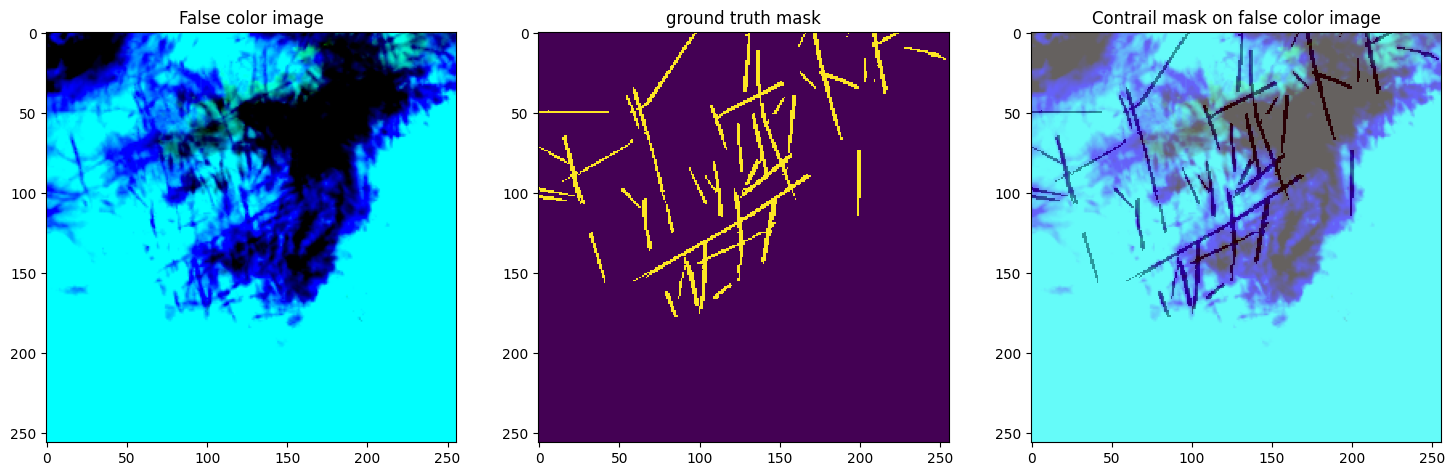

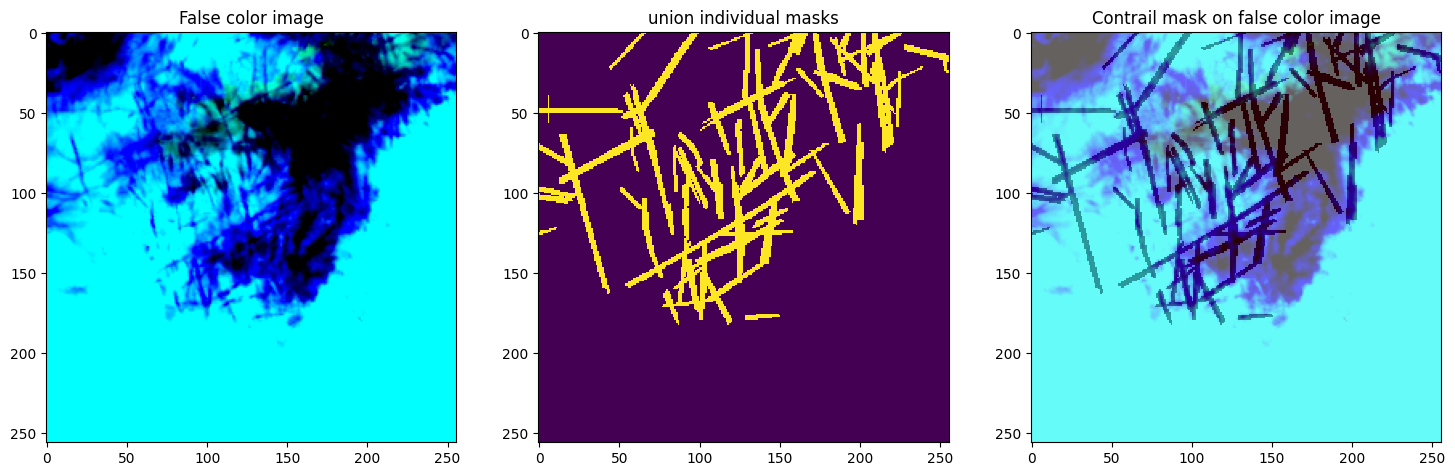

In [38]:
dataset_train = ContrailsDatasetMixed(split = "train",mode= "single", delta_t = 0)
img, [label_ground_truth, label_union] = dataset_train.__getitem__(0)

for i in range(2):
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(({0:label_ground_truth,1:label_union}[i]), interpolation='none')
    ax.set_title({0:"ground truth mask",1:"union individual masks"}[i])

    ax = plt.subplot(1, 3, 3)
    ax.imshow(img.permute(1,2,0))
    ax.imshow({0:label_ground_truth,1:label_union}[i], cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

## Lightning Module Custom Tversky Loss
This Lightning module implements the custom loss function.  
The hyperparameters for the loss function are set in the config dictionary, but changed via the training function parameter.

In [ ]:
class LightningModuleTrLoss(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # print(config["aux_params"])
        self.model = model = smp.Unet(
            encoder_name=config["encoder_name"],
            encoder_depth=config["encoder_depth"],
            decoder_channels = (256, 128, 64, 32,16)[:config["encoder_depth"]],
            # aux_params = config["aux_params"],
            decoder_attention_type =config["decoder_attention_type"],
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None,
        )
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []
        self.alpha = config["alpha"]
        self.beta = config["beta"]
        self.alpha_union = config["alpha_union"]
        self.beta_union = config["beta_union"]

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"]["CosineAnnealingLR"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"]["ReduceLROnPlateau"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
        elif self.config["scheduler"]["name"] == "cosine_with_hard_restarts_schedule_with_warmup":
            scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}


    def training_step(self, batch, batch_idx):
        imgs, [label_gt,label_union] = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss_ground_truth = smp.losses.TverskyLoss("binary", classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-06, alpha=self.alpha, beta=self.beta, gamma=1.0)(preds, label_gt)
        loss_union = smp.losses.TverskyLoss("binary", classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-06, alpha=self.alpha_union, beta=self.beta_union, gamma=1.0)(preds, label_union)
        loss = torch.mul(loss_ground_truth,self.config["weight_ground_truth"])+torch.mul(loss_union, self.config["weight_union"])
        self.log('loss_union', float(loss_union) , on_step=False, on_epoch=True, prog_bar=True) #, batch_size=16
        self.log('loss_ground_truth', float(loss_ground_truth) , on_step=False, on_epoch=True, prog_bar=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

## Function to train the model with certain hyperparamters

The sample_loss_parameters function can be used to train the model with different hyperparameters. The performance is tracked via the csv_logger and can later be plotted to compare the performance of the model on the validation dataset.

In [ ]:
def sample_loss_parameters(delta, cfg, module,alpha, alpha_union, weight_ground_truth):
    cfg['model']["alpha"] = alpha
    cfg['model']["beta"] = 1-alpha
    cfg['model']["alpha_union"] = alpha_union
    cfg['model']["beta_union"] = 1-alpha_union
    cfg['model']["weight_ground_truth"] = weight_ground_truth
    cfg['model']["weight_union"] = 1-weight_ground_truth
    identifier = "resnest26d_alpha="+str(alpha)+"_alpha_union="+str(alpha_union)+"_weight_ground_truth="+str(weight_ground_truth)
    dataset_train = ContrailsDatasetMixed("train", "single",delta)
    dataset_validation = ContrailsDatasetMixed("validation","single", delta)
    
    data_loader_train = DataLoader(
    dataset_train,
    batch_size=cfg["train_bs"],
    shuffle=True,
    num_workers=cfg["workers"],
    )
    
    data_loader_validation = DataLoader(
        dataset_validation,
        batch_size=cfg["valid_bs"],
        shuffle=False,
        num_workers=cfg["workers"],
    )
    
    checkpoint_callback = ModelCheckpoint(
    save_weights_only=True,
    monitor="val_dice",
    dirpath=cfg["output_dir"],
    mode="max",
    filename= identifier,
    save_top_k=1,
    verbose=1,
    )
    
    progress_bar_callback = TQDMProgressBar(
    refresh_rate=cfg["progress_bar_refresh_rate"]
    )

    early_stop_callback = EarlyStopping(**cfg["early_stop"])
    csv_logger = CSVLogger(cfg["output_dir"], name=identifier)
    trainer = L.Trainer(
        callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback], logger = csv_logger,
        **cfg["trainer"],
    )
    
    # cfg["model"]["scheduler"]["params"]["CosineAnnealingLR"]["T_max"] *= len(data_loader_train)/cfg["trainer"]["devices"]
    model = module(cfg["model"])
    
    trainer.fit(model, data_loader_train, data_loader_validation)
    
    

### Baseline: Dice/F1-Score of Ground truth only

In [ ]:
# Baseline
sample_loss_parameters(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = 0.5,alpha_union = 0.5, weight_ground_truth = 1)

### Sample tversky parameter and weight

In [ ]:
for weight_ground_truth in [0.6,0.7]:
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            # sample_loss_parameters(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = alpha,alpha_union = alpha_union, weight_ground_truth = weight_ground_truth)

### Visualize the results

In [67]:
def visualize(weight_ground_truth, all_alpha, all_alpha_union):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,20))
    for alpha in all_alpha:
        for alpha_union in all_alpha_union:
            path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            best_epoch = " max: {:.3f}".format(maximum)
            parameters = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            label = best_epoch + " | " + parameters
            linestyle = {0.4:"dotted",0.6:"--",0.8:"-"}[alpha_union]
            color = {0.35:(0.6,0,0),0.5:(0,0,0.5),0.65:(0, 0.6, 0)}[alpha]
            plt.plot(metrics['val_dice'], label=label, linestyle = linestyle, color = color)
            print(label)
    plt.legend()
    plt.show()

    data = []
    dice_list = []
    for alpha in all_alpha:
        for alpha_union in all_alpha_union:
            path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            label = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            data.append([alpha, alpha_union, maximum])
            dice_list.append(f" max: {maximum:.3f} "+label)
    

    x = [i[0] for i in data]
    y = [i[1] for i in data]
    z = [i[2] for i in data]

    # plt.figure(figsize=(15,15))
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a mesh grid
    X,Y = np.meshgrid(x,y)

    # Interpolate the data
    from scipy.interpolate import griddata
    Z = griddata((x,y), z, (X,Y), method='cubic')

    # Plot the points with a color gradient
    ax.scatter(x,y,z,c=z,cmap='coolwarm', alpha=1)

    # Add a color bar which maps values to colors
    # fig.colorbar(surf)

    # Plot lines from points to surface
    for i in range(len(x)):
        ax.plot([x[i], x[i]], [y[i], y[i]], [0.615, z[i]], color='black', alpha=0.5)

    # Plot the surface
    ax.set_xlabel('alpha')
    ax.set_ylabel('alpha_union')
    ax.set_zlabel('maximum')

    plt.show()



In [104]:
def visualize_with_baseline(weight_ground_truth, all_alpha, all_alpha_union):
    print("weight_ground_truth=",weight_ground_truth)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,20))
    for alpha in all_alpha:
        for alpha_union in all_alpha_union:
            path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            best_epoch = "max: {:.3f}".format(maximum)
            parameters = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            label = best_epoch + " | " + parameters
            linestyle = {0.4:"dotted",0.6:"--",0.8:"-"}[alpha_union]
            color = {0.35:(0.6,0,0),0.5:(0,0,0.5),0.65:(0, 0.6, 0)}[alpha]
            plt.plot(metrics['val_dice'], label=label, linestyle = linestyle, color = color)
            print(label)

    path = f"metrics/resnest26d_alpha=0.5_alpha_union=0.5_weight_ground_truth=1/version_0/metrics.csv"
    metrics = pd.read_csv(path)
    metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
    maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
    best_epoch = "max: {:.3f}".format(maximum)
    parameters = "alpha=0.5_weight_ground_truth=1 / dice loss"
    label = best_epoch + " | " + parameters
    linestyle = "dashdot"
    color = (0,0,0)
    plt.plot(metrics['val_dice'], label=label, linestyle = linestyle, color = color)
    print(label)
    plt.legend()
    plt.show()

    data = []
    dice_list = []
    for alpha in all_alpha:
        for alpha_union in all_alpha_union:
            path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            label = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            data.append([alpha, alpha_union, maximum])
            dice_list.append(f" max: {maximum:.3f} "+label)
    

    x = [i[0] for i in data]
    y = [i[1] for i in data]
    z = [i[2] for i in data]

    # plt.figure(figsize=(15,15))
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a mesh grid
    X,Y = np.meshgrid(x,y)

    # Interpolate the data
    from scipy.interpolate import griddata
    Z = griddata((x,y), z, (X,Y), method='cubic')

    # Plot the points with a color gradient
    ax.scatter(x,y,z,c=z,cmap='coolwarm', alpha=1)

    # Add a color bar which maps values to colors
    # fig.colorbar(surf)

    # Plot lines from points to surface
    for i in range(len(x)):
        ax.plot([x[i], x[i]], [y[i], y[i]], [0.613, z[i]], color='black', alpha=0.5)

    # Plot the surface
    ax.set_xlabel('alpha')
    ax.set_ylabel('alpha_union')
    ax.set_zlabel('maximum')

    plt.show()



#### Visualizations

The first plot show the val_dice score of the different models over the epochs

The second plot shows the best achieved val_dice score of each model.  
Here, if the model performed worse than baseline, the line goes down to the point, and if the model performed better, the line goes up to the point.

##### Loss function = 0.7*tversky(..) + 0.3\*tversky()

weight_ground_truth= 0.7
max: 0.612 | alpha=0.35_alpha_union=0.4_weight_ground_truth=0.7
max: 0.613 | alpha=0.35_alpha_union=0.6_weight_ground_truth=0.7
max: 0.613 | alpha=0.35_alpha_union=0.8_weight_ground_truth=0.7
max: 0.615 | alpha=0.5_alpha_union=0.4_weight_ground_truth=0.7
max: 0.619 | alpha=0.5_alpha_union=0.6_weight_ground_truth=0.7
max: 0.616 | alpha=0.5_alpha_union=0.8_weight_ground_truth=0.7
max: 0.610 | alpha=0.65_alpha_union=0.4_weight_ground_truth=0.7
max: 0.619 | alpha=0.65_alpha_union=0.6_weight_ground_truth=0.7
max: 0.615 | alpha=0.65_alpha_union=0.8_weight_ground_truth=0.7
max: 0.613 | alpha=0.5_weight_ground_truth=1 / dice loss


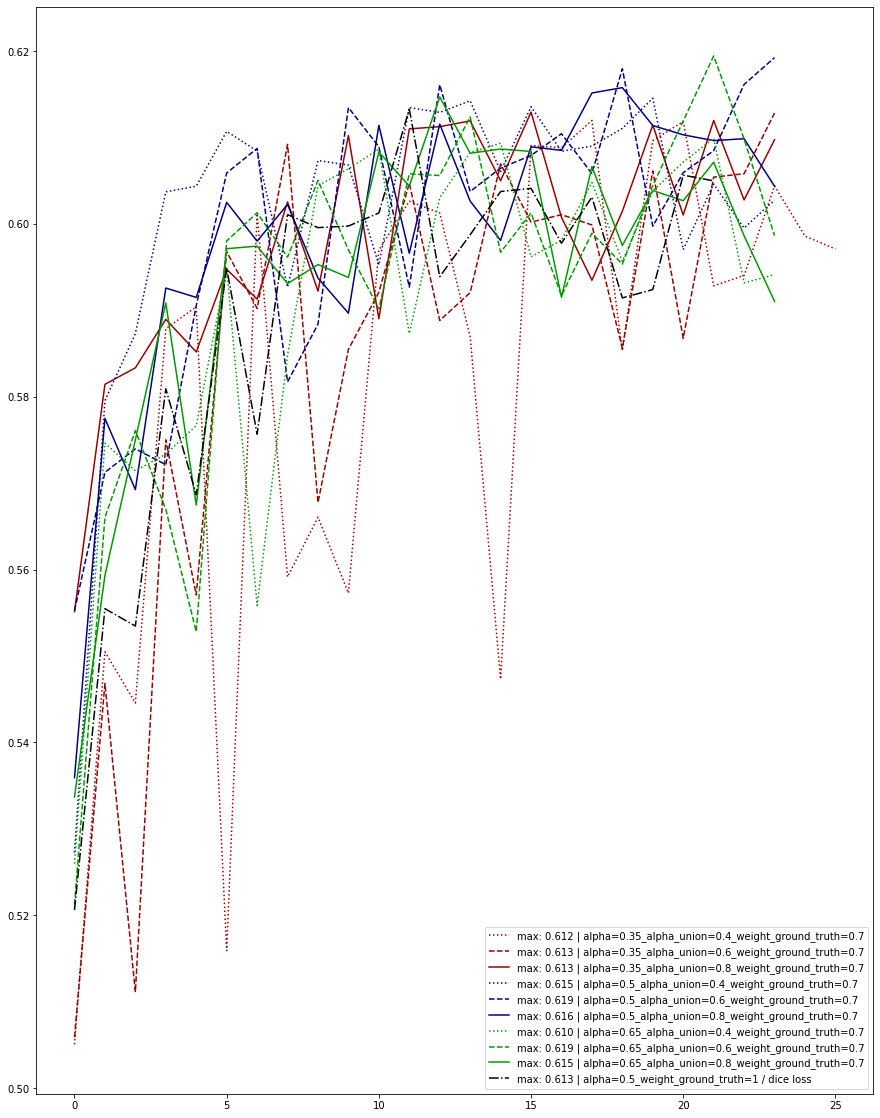

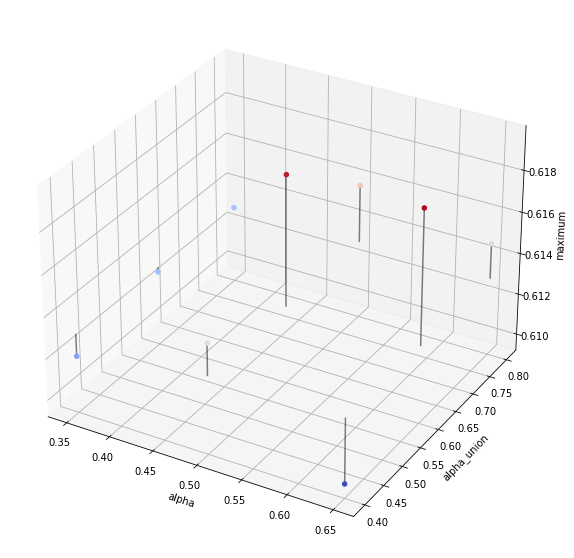

weight_ground_truth= 0.6
max: 0.607 | alpha=0.35_alpha_union=0.4_weight_ground_truth=0.6
max: 0.612 | alpha=0.35_alpha_union=0.6_weight_ground_truth=0.6
max: 0.614 | alpha=0.35_alpha_union=0.8_weight_ground_truth=0.6
max: 0.616 | alpha=0.5_alpha_union=0.4_weight_ground_truth=0.6
max: 0.623 | alpha=0.5_alpha_union=0.6_weight_ground_truth=0.6
max: 0.625 | alpha=0.5_alpha_union=0.8_weight_ground_truth=0.6
max: 0.615 | alpha=0.65_alpha_union=0.4_weight_ground_truth=0.6
max: 0.619 | alpha=0.65_alpha_union=0.6_weight_ground_truth=0.6
max: 0.616 | alpha=0.65_alpha_union=0.8_weight_ground_truth=0.6
max: 0.613 | alpha=0.5_weight_ground_truth=1 / dice loss


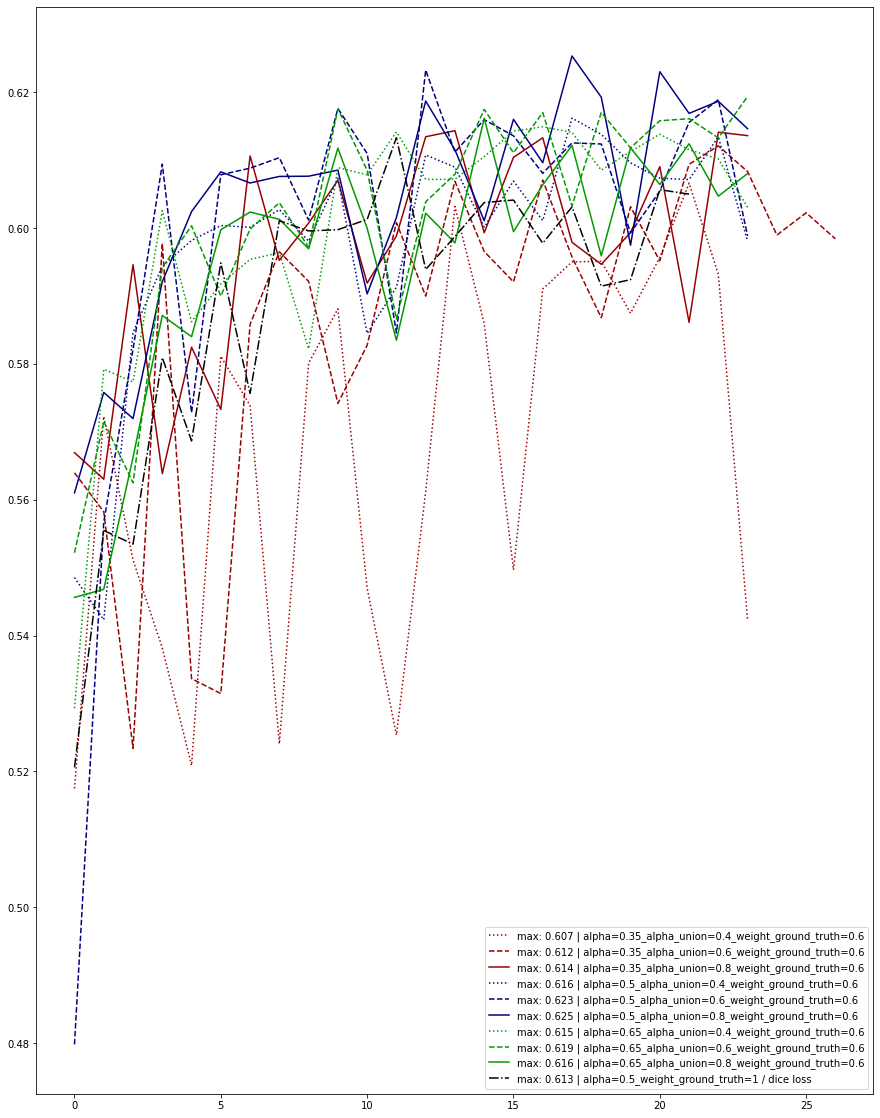

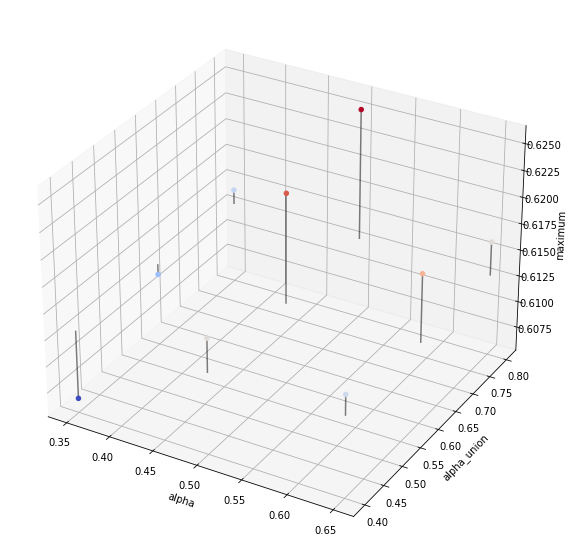

In [105]:
alpha = [0.35,0.5,0.65]
alpha_union = [0.4,0.6,0.8]


weight_ground_truth = 0.7
visualize_with_baseline(weight_ground_truth, alpha, alpha_union)




##### Loss function = 0.6*tversky(..) + 0.4\*tversky()

In [ ]:
weight_ground_truth = 0.6
visualize_with_baseline(weight_ground_truth, alpha, alpha_union)

### Results
#### Performance
Interestingly, the best alpha and alpha union parameter combination depends a lot on how two loss functions are weighted in the final, combined loss function.  
Weighting the loss of the ground truth a little less, with 60%, seems to result in better models as well as to incease the discrepancy between the best and worst performing alpha and alpha union parameter.

Also, 

#### Training speed

Fst Conclusion